In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fftpack import fft, ifft
from scipy.signal import cwt, morlet
from pydmd import DMD
from pydmd.plotter import plot_eigs
# %matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import seaborn as sns
import pywt
from IPython.display import HTML
import scipy
from functools import partial

# Discretization, Memory Allocation, Initial Condition

In [2]:
# Discretization
Xlngth = 10  # X Length of domain
Xnum = int(1e3)  # X number of cells
dx = Xlngth/Xnum  # X length between cells

kx = np.fft.fftfreq(Xnum, dx)  # Wave numbers in Fourier space

Tlngth = .05  # T length of time domain
snaps = 20  # number of snapshots
cursnap = 0
dt = Tlngth/snaps

In [3]:
nmean = 3/(4*np.pi)
Gamma = 1
kappa = 1
therm_cond = 1
eta = 1

In [4]:
# Initialize domain
X = np.linspace(0,Xlngth,Xnum+1)[:-1]
Snap = np.linspace(0,Tlngth, num=snaps+1, endpoint=True)

# Initialize variables at cell centroids
n = np.zeros(Xnum).astype(float)  # Density
v = np.zeros(Xnum).astype(float)  # Velocity
e = np.zeros(Xnum).astype(float)  # Temperature
phi = np.zeros(Xnum).astype(float)  # Electrostatic Potential

# Initialize fluxes at cell faces
Fn = np.zeros(Xnum).astype(float)
Fv = np.zeros(Xnum).astype(float)
Fe = np.zeros(Xnum).astype(float)

# Initialize storage of variables
ntot = np.stack([n]*(snaps+1)).astype(float)
vtot = np.stack([v]*(snaps+1)).astype(float)
etot = np.stack([e]*(snaps+1)).astype(float)
phitot = np.stack([phi]*(snaps+1)).astype(float)

In [5]:
# Create Initial Conditions
def def_IC(X, option, *args):
    if option == 'gaussian':
        # Gaussian Initial Condition
        mu = Xlngth / 2
        sigma = 0.2 * Xlngth
        initial_condition = np.exp(-((X - mu)**2) / (2 * sigma**2))/(sigma*np.sqrt(2*np.pi))

    elif option == 'hat':
        # Hat (Step) Function Initial Condition
        initial_condition = np.where((X >= 0.4 * Xlngth) & (X <= 0.6 * Xlngth), 1.0, 0.0)

    elif option == 'constant':
        # Constant Initial Condition
        initial_condition = np.ones(Xnum)

    elif option == 'random':
        # Random Initial Condition
        np.random.seed(123)  # Seed for reproducibility
        initial_condition = np.random.rand(Xnum)

    elif option == 'sinusoidal':
        # Sinusoidal Initial Condition (with frequency = 3)
        frequency = args[0]
        initial_condition = np.sin(2 * np.pi * frequency * X / Xlngth)
        
    elif option == 'zero':
        # Zero Initial Condition
        initial_condition = np.zeros(Xnum)

    else:
        raise ValueError("Invalid initial condition option")

    return initial_condition

def half_domain_shift(arr):
    return np.roll(arr, shift = int(Xnum/2), axis = -1)

In [6]:
# Initialize Initial Condition
prtrb_ampltd = [.1, .05, .025, .01]
n = nmean + prtrb_ampltd[0]*nmean*def_IC(X, "sinusoidal", 3) \
#     - prtrb_ampltd[2]*def_IC(X, "sinusoidal", 3) \
#     + prtrb_ampltd[2]*def_IC(X, "sinusoidal", 5) \
#     - prtrb_ampltd[2]*def_IC(X, "sinusoidal", 7) \
#     + prtrb_ampltd[2]*def_IC(X, "sinusoidal", 11) \
#     - prtrb_ampltd[1]*def_IC(X, "random")
        
v = 1 + prtrb_ampltd[0]*def_IC(X, "zero")
# v = 0 + prtrb_ampltd[0]*def_IC(X, "zero")
e = 1 + prtrb_ampltd[0]*def_IC(X, "zero")

# n = half_domain_shift(n)
# v = half_domain_shift(v)
# e = half_domain_shift(e)

ICs = (n, v, e)
ICs = np.concatenate(ICs)

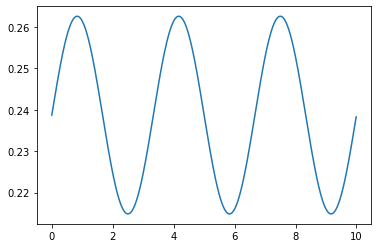

In [7]:
plt.plot(X,n)

# Physics

In [8]:
# Define methods for retrieving neighbor elements
def l(arr):
    return np.roll(arr, shift=1, axis=-1)

def r(arr):
    return np.roll(arr, shift=-1, axis=-1)
    
def ddx(arr):
    return (arr-l(arr))/dx

def ddx_c(arr):
    return (r(arr)-l(arr))/(2*dx)

def d2dx2(arr):
    return (l(arr)-2*arr+r(arr))/(dx**2)

def thomas_algorithm(A, B, C, D):  # 100% Checked. With all randoms on all arrays. Seriously. Solid. Don't Touch.
    """
    Solve a tridiagonal matrix using the Thomas Algorithm.
    Mx = D
    
    Parameters:
    - A,B,C: 1D arrays that make up the subdiagonal, diagonal, and super diagonal nonzero elements of the tridiagonal matrix
                with shapes (Xnum-1,), (Xnum,), and (Xnum-1,), respectively.
    - x: 1D array meant to represent the input vector where x.shape=(Xnum,).
    - D: 1D array meant to represent the output vector where D.shape=(Xnum,).

    Returns:
    - x: vector solution
    """ 
    x = np.zeros(Xnum)    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    # Forward elimination
    for i in range(0, Xnum-1):
        w = a[i] / b[i]
        b[i+1] -= w * c[i]
        d[i+1] -= w * d[i]

    # Backward substitution
    x[-1] = d[-1] / b[-1]
    for i in range(Xnum - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
        
    return x    
    
def modified_thomas_algorithm(A, B, C, D):
    """ 
    Modified Thomas Algorithm to solve tridiagonal matrix with periodic boundary conditions.
    Use Shermann Morrison Theorem to find rank-1 perturbation to separate non tirdiagonal entries and solve using Thomas Algorithm
    """
    x = np.zeros(Xnum)
    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    u = np.zeros(Xnum)
    v = np.zeros(Xnum)
    y = np.zeros(Xnum)
    q = np.zeros(Xnum)
    
    gamma_ta = 1  # Parameter chosen to reduce complexity of Shermann-Morrison Algorithm 
    c[-1] = 0  # Account for Gauge Invariance of Poisson Equation / Ensure invertibility of Laplacian with Periodic BC
    
    u[0] = gamma_ta
    u[-1] = c[-1]
    
    v[0] = 1
    v[-1] = a[0] / gamma_ta

    # Modify vectors A, B, and C
    Ba = a[1:]
    
    Bb = np.copy(b)
    Bb[0] -= gamma_ta
    Bb[-1] -= (c[-1] * a[0]) / gamma_ta
    
    Bc = c[:-1]
    
    y = thomas_algorithm(Ba, Bb, Bc, d)
    q = thomas_algorithm(Ba, Bb, Bc, u)

    Value = (v[0] * y[0] + v[-1] * y[-1]) / (1 + v[0] * q[0] + v[-1] * q[-1])
    
    x = y - q * Value
    
    return x

def solve_poisson(Xnum, n): # TODO: Fix Poisson
    """
    Special version of Thomas Algorithm from "Computer Simulation Using Particles" by Hockney and Eastwood pg. 35-39 and 185.
    When solving a Laplacian with periodic boundary conditions for a quantity with gauge invariance, this O(n) algorithm can be used.
    """
    phi = np.zeros(Xnum)

    p = np.arange(1, Xnum+1)
    
    phi[0] = np.sum(p *n) / Xnum

    phi[1] = n[0] + 2 * phi[0]

#     for jj in range(10):
    for ii in range(2, Xnum):
        phi[ii] = n[ii-1] + 2 * phi[ii-1] - phi[ii-2]
        
    return phi

# phi = solve_poisson(10,np.arange(10))
# print(phi)
# print(ddx(phi))



def DCF(r_prime, e, q, lambda_s):
    # Define DCF(r) using the given approximation with 1/e
    return np.exp(-(1 / e) * phi_r_prime(r_prime, q, lambda_s)) - 1

def phi_r_prime(r_prime, q, lambda_s):
    # Define phi(r') using the given formula
    return (q**2 / r_prime) * np.exp(-r_prime / lambda_s)

def correlation():
    corr = np.zeros(Xnum)

    for i in range(Xnum):
        r_prime = np.linspace(0, np.inf, Xnum)  # Discretize r' over [0, inf]
        integrand = (DCF(r_prime, e[i], q, lambda_s) / e[i]) * r_prime * np.sin(np.abs(kx[i]) * r_prime)
        corr[i] = 8 * np.pi**3 * ifft(1 / np.abs(kx[i]) * fft((n - nmean) * integrand)).real

def flux(t, y):
    n = y[:Xnum]  # Extract density component
    v = y[Xnum:2*Xnum]  # Extract velocity component
    e = y[2*Xnum:3*Xnum]  # Extract temperature component
    
    # [b1 c1 ...    a1]
    # [a2 b2 c2 ...  0]
    # [0  a3 b3 c3 ...]
    # [cn 0... an-1 bn]
    # Set cn = 0 to prevent singularity
    
    phimtx_sub = np.ones(Xnum)
    phimtx_diag = -2*np.ones(Xnum)
    phimtx_sup = np.ones(Xnum)
    phi_rhs = dx*dx*(-4*np.pi*(n-np.mean(n)))  # Found by substituting in nmean
    # phi_rhs = 3-4*np.pi* dx * dx * n
    phi = modified_thomas_algorithm(phimtx_sub, phimtx_diag, phimtx_sup, phi_rhs)
    # phi = solve_poisson(Xnum, 3-4*np.pi*n)
    
    flux_n = - ddx(n*v)
    flux_v = - ddx(0.5*v*v) - ddx(e*n)/n + eta/n*d2dx2(v) - Gamma*ddx(phi) # TODO: Fix phi
    flux_e = e*v*ddx(n)/n - (2/3)*e*ddx(v) + therm_cond*d2dx2(e)/(3*n)
    flux_sys = np.concatenate((flux_n, flux_v, flux_e))
    
    ### TODO: NOTE TO MURILLO: Choice of Gauge Invariance Changes Solution. cn = 0 or a1 = 0 leads to reverse ordering in solution
    
    ### Error: cursnap referenced before assignment ###
#     if t >= Snap[cursnap]:
#         print(round(100*t/Tlngth,2),"%")
#         cursnap += 1
    
    return flux_sys

In [9]:
# Solve PDEs
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, method='Radau', t_eval=Snap)
sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, t_eval=Snap)
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs)
# solc = solve_ivp(fun=flux_c, t_span=[0,Tlngth], y0=ICs, t_eval=Snap)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 18098
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.0325, 0.035 , 0.0375,
       0.04  , 0.0425, 0.045 , 0.0475, 0.05  ])
 t_events: None
        y: array([[0.23873241, 0.23861986, 0.2385076 , ..., 0.23673265, 0.23662356,
        0.23651472],
       [0.23918239, 0.23907003, 0.23895752, ..., 0.23717867, 0.23706916,
        0.23695989],
       [0.2396322 , 0.23951968, 0.23940736, ..., 0.23762523, 0.23751534,
        0.23740567],
       ...,
       [1.        , 1.00047009, 1.00093393, ..., 1.00760659, 1.00797929,
        1.00834705],
       [1.        , 1.00046939, 1.00093323, ..., 1.00760542, 1.00797837,
        1.00834642],
       [1.        , 1.00046932, 1.0009322 , ..., 1.00760153, 1.00797459,
        1.00834278]])
 y_events: None


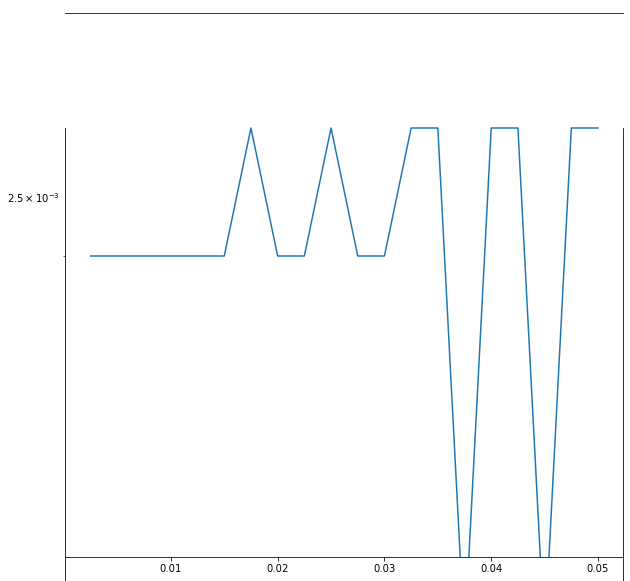

In [10]:
ntot = sol.y[:Xnum].reshape(Xnum, -1).T
vtot = sol.y[Xnum:2*Xnum].reshape(Xnum, -1).T
etot = sol.y[2*Xnum:].reshape(Xnum, -1).T

T = sol.t

# nctot = solc.y[:Xnum].reshape(Xnum, -1)
# vctot = solc.y[Xnum:2*Xnum].reshape(Xnum, -1)
# ectot = solc.y[2*Xnum:].reshape(Xnum, -1)

# Tc = solc.t

print(sol)

time_steps = np.linspace(0,T.max(),len(T))

# min_dt = np.min(np.diff(T))
# max_dt = np.max(np.diff(T))

plt.figure(figsize=(10,10))
plt.semilogy(time_steps[1:], (T-l(T))[1:])

### 4 pi q^2 n_0 / m = w_p ###

In [11]:
print(len(ntot))
print(len(ntot[0]))

21
1000


# Plotting: Wavelets

(21,)


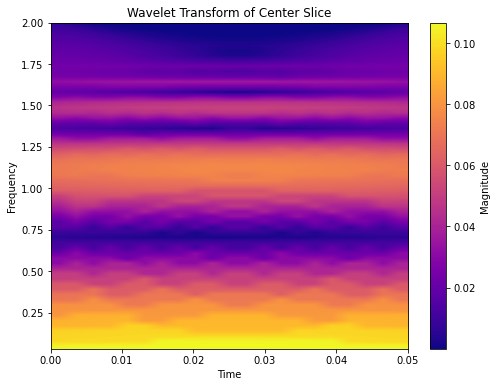

(array([[ 2.20067210e-07-7.64282686e-03j, -3.13191829e-04-4.60983338e-03j,
         -1.36628543e-04-1.01580059e-03j, ...,
         -1.63772614e-05+7.20070808e-05j, -1.38057550e-04+1.00843721e-03j,
         -3.16574740e-04+4.64058285e-03j],
        [ 6.68996638e-07-1.08149298e-02j, -3.23649642e-04-9.53469227e-03j,
         -4.42715235e-04-6.53011520e-03j, ...,
         -3.56093505e-04+3.46626897e-03j, -4.47909272e-04+6.55202757e-03j,
         -3.28029772e-04+9.59381961e-03j],
        [ 1.75760488e-06-1.32291372e-02j, -1.02614306e-02+7.19238164e-03j,
          9.01830971e-03+5.44950343e-03j, ...,
         -5.49085823e-04+8.05213581e-03j,  9.10921528e-03-5.49846583e-03j,
         -1.03613385e-02-7.26449529e-03j],
        ...,
        [-5.20974141e-02-8.24946245e-02j, -3.53503463e-02-9.12055877e-02j,
         -1.71914192e-02-9.65237287e-02j, ...,
          2.75222365e-03+9.82009261e-02j, -1.61560958e-02+9.67087408e-02j,
         -3.43801219e-02+9.15965260e-02j],
        [-5.25455595e-02-8.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

def wavelet_transform(data, scales=np.arange(1, 16), wavelet_name = 'cmor5-1.5', t=Snap):
    """
    Perform a wavelet transformation on spatio-temporal data.

    Parameters:
    data (ndarray): Spatio-temporal data with shape (time, space).
    scales (ndarray): Array of scales at which to compute the CWT.

    Returns:
    coefs (ndarray): Wavelet coefficients.
    freqs (ndarray): Corresponding frequencies.
    """
    # Check if data is a 2D array
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array")

    # Select the center slice from the space axis
    center_slice = data[:, data.shape[1] // 2]

    # Perform the Continuous Wavelet Transform
    coefs, freqs = pywt.cwt(center_slice, scales, wavelet_name)
    
    print(center_slice.shape)

    # freqs /= dt
    
    extent = [0, t.max(), freqs.min(), freqs.max()]
    # Plot the wavelet coefficients
    fig = plt.figure(figsize=(8,6))
    plt.imshow(np.abs(coefs), aspect='auto', extent=extent, interpolation='bilinear', cmap='plasma')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.title('Wavelet Transform of Center Slice')
    plt.show()

    return coefs, freqs

# Define scales for the wavelet transform
scales = np.arange(1, 64)
wavelet_transform(ntot, scales, wavelet_name = 'cmor2-2')
# .8 IC = 'cmor2-3'
# .05 IC = 'cmor2-3'

# Example usage
# if __name__ == "__main__":
#     # Create a sample spatio-temporal dataset
#     time = np.linspace(0, 2*np.pi, 100)
#     space = np.linspace(0, 10, 50)
#     data = np.sin(2 * np.pi * time) + np.sin(2 * np.pi * 2 * time)

#     time_mesh, space_mesh = np.meshgrid(time, space, indexing='ij')
#     fig = plt.figure(figsize=(6,6))
#     plt.plot(time, data)
    
#     fig = plt.figure(figsize=(6,6))
#     fft = np.fft.fftshift(np.fft.fft(data))
#     fft_x = np.fft.fftshift(np.fft.fftfreq(100, 2*np.pi))
    
#     print(fft_x)
    
#     plt.plot(fft_x, np.abs(fft))
    
#     data = (data*space_mesh.T).T

#     fig = plt.figure()
#     plt.pcolormesh(space, time, data)
    
#     # Define scales for the wavelet transform
#     scales = np.arange(1, 64)
    
#     wavelet_transform(data, scales)

# Plotting: Line Plots

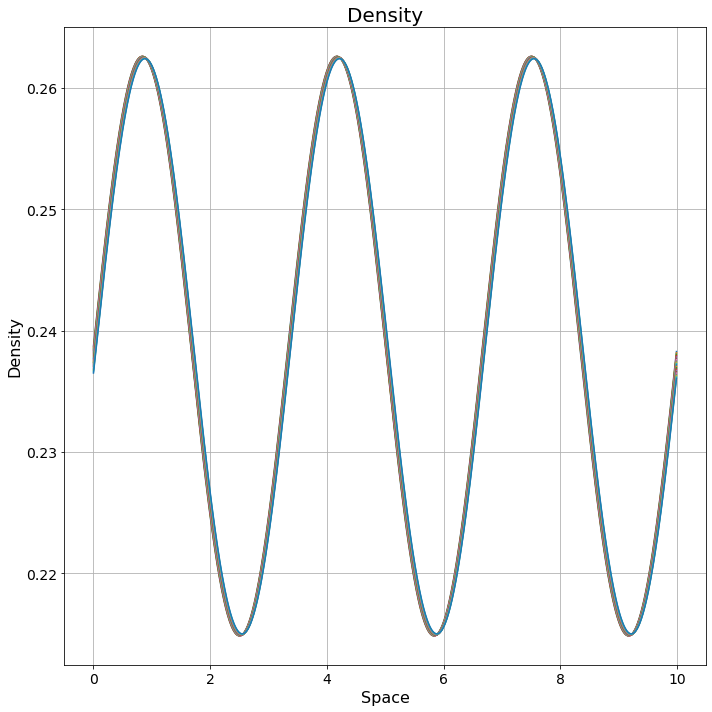

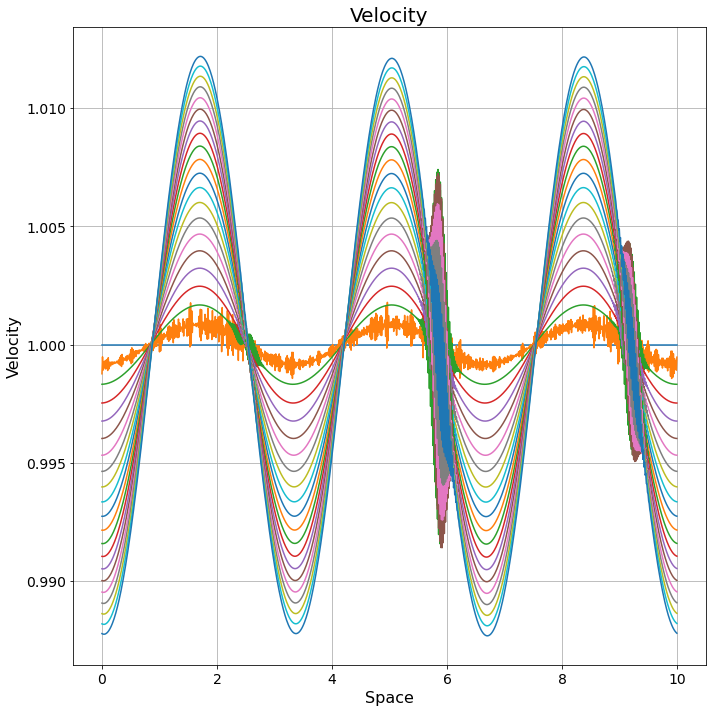

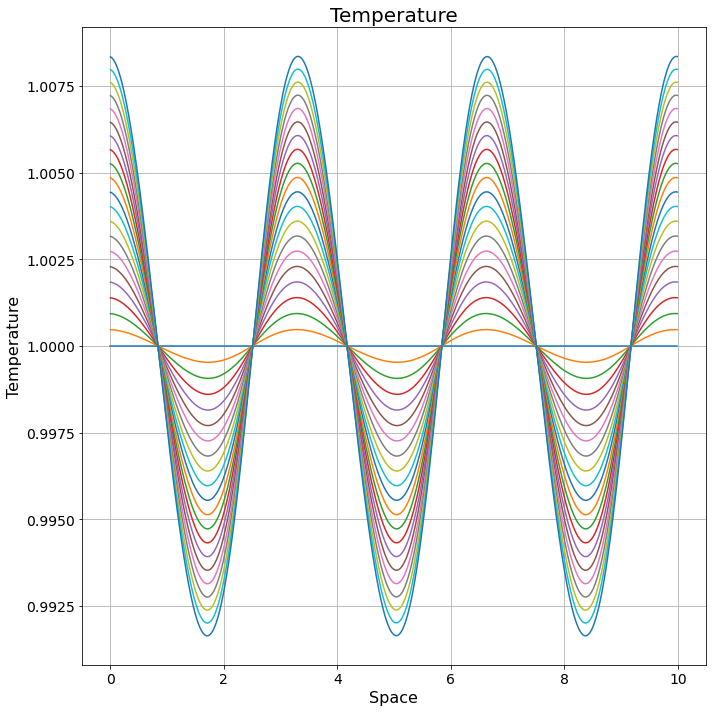

In [13]:
def line_plots(X, data, titles, ylabels, num_time_plots):
    """
    Plot line plots for the provided data.
    
    Parameters:
    - X: x-axis data
    - data: list of y-axis data arrays
    - titles: list of titles for the plots
    - ylabels: list of y-labels for the plots
    - num_time_plots: indices for the time plots
    """
    for d, title, ylabel in zip(data, titles, ylabels):
        fig, ax = plt.subplots(figsize=single_plot_figsize)
        ax.plot(X, d.T[:, num_time_plots])
        ax.set_title(title, fontsize=20)  # increased font size for title
        ax.set_xlabel("Space", fontsize=16)  # increased font size for x-label
        ax.set_ylabel(ylabel, fontsize=16)  # increased font size for y-label
        ax.tick_params(axis='both', which='major', labelsize=14)  # increased font size for tick labels
        ax.grid(True)
        plt.tight_layout()

num_time_plots = np.arange(0, len(T))
single_plot_figsize = (10, 10)

data = [ntot, vtot, etot]
titles = ["Density", "Velocity", "Temperature"]
ylabels = ["Density", "Velocity", "Temperature"]

line_plots(X, data, titles, ylabels, num_time_plots)

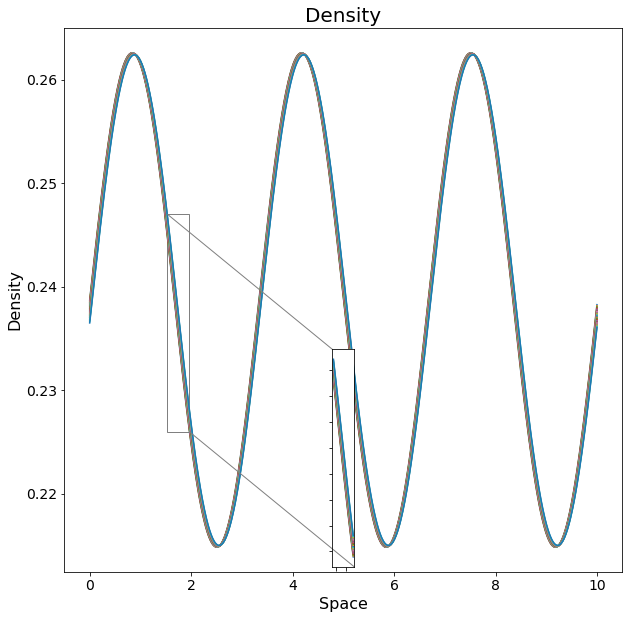

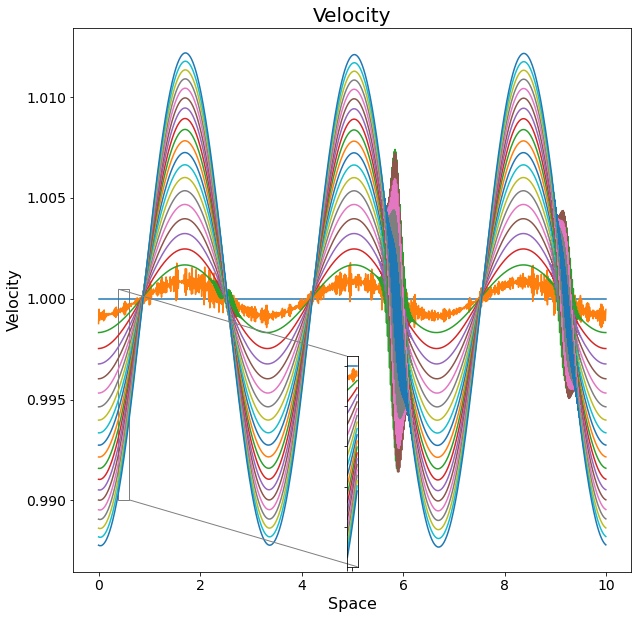

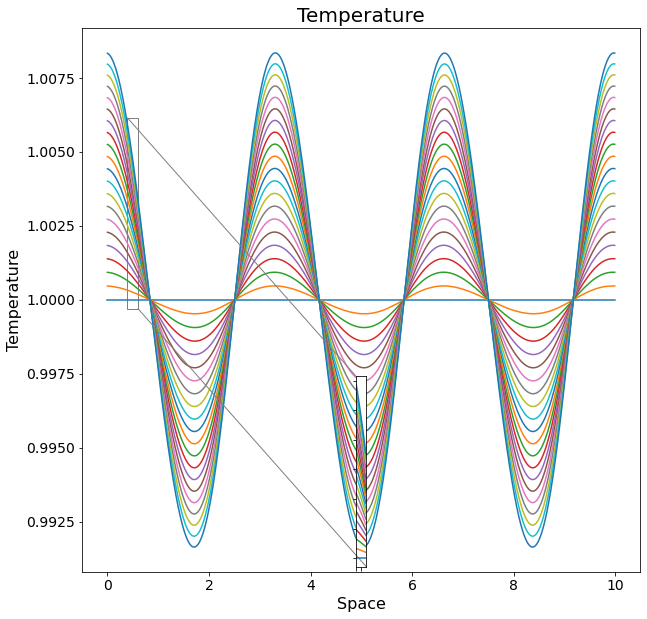

In [14]:
def line_plots_with_zoom(X, data, titles, ylabels, zoom_ranges, num_time_plots, figsize):
    """
    Plot line plots with zoomed-in insets for the provided data.

    Parameters:
    - X: x-axis data
    - data: list of y-axis data arrays
    - titles: list of titles for the plots
    - ylabels: list of y-labels for the plots
    - zoom_ranges: list of tuple ranges for zoom
    - num_time_plots: indices for the time plots
    - figsize: tuple representing figure size
    """
    for d, title, ylabel, zoom_range in zip(data, titles, ylabels, zoom_ranges):
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(X, d.T[:, num_time_plots])
        ax.set_title(title, fontsize=20)
        ax.set_xlabel("Space", fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)

        axins = zoomed_inset_axes(ax, 1, loc=8)
        axins.plot(X[zoom_range[0]:zoom_range[1]], d.T[zoom_range[0]:zoom_range[1], num_time_plots])
        plt.xticks(visible=False)
        plt.yticks(visible=False)
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
        
        plt.show()

single_plot_figsize = (10, 10)

data = [ntot, vtot, etot]
titles = ["Density", "Velocity", "Temperature"]
ylabels = ["Density", "Velocity", "Temperature"]
zoom_ranges = [(155, 195), (40, 60), (40, 60)]  # Specified zoom ranges

line_plots_with_zoom(X, data, titles, ylabels, zoom_ranges, num_time_plots, single_plot_figsize)


# Plotting: Colormaps

(<Figure size 720x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Temperature'}, xlabel='Time', ylabel='Space'>)

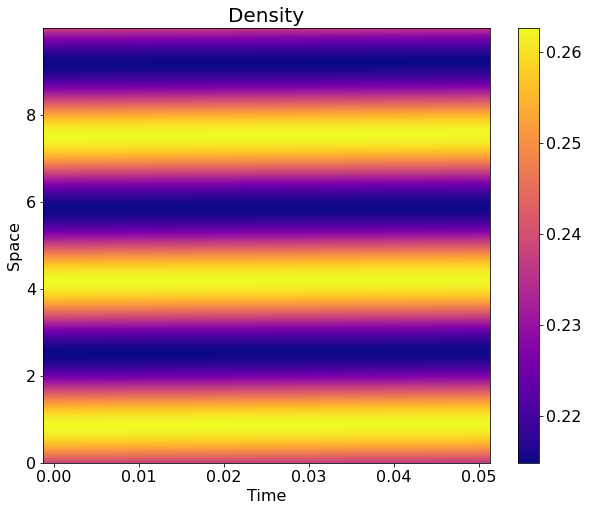

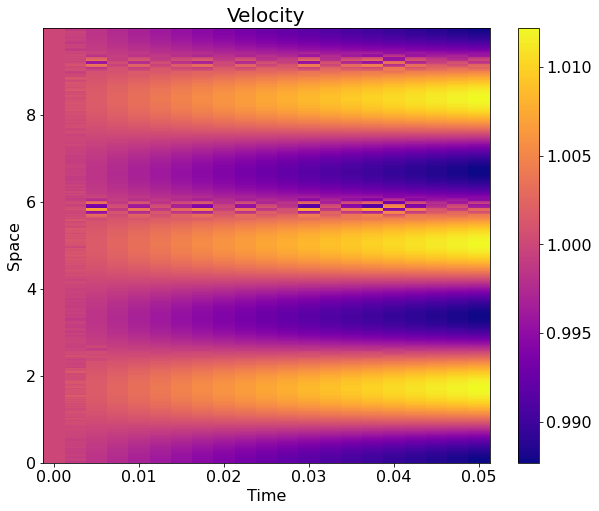

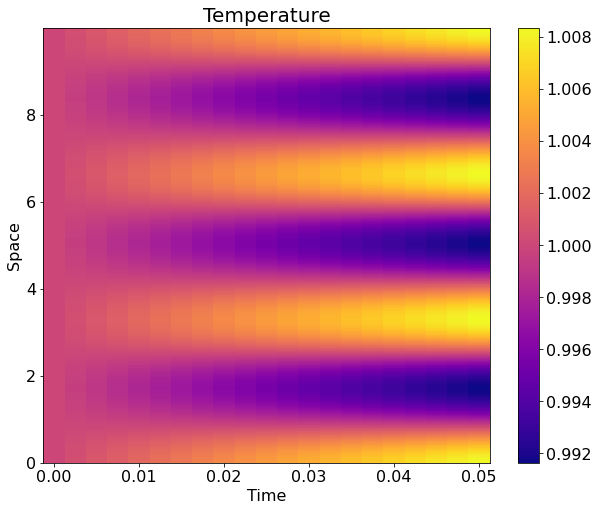

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def colormaps(X, T, data, title, xlabel, ylabel, figsize=(10,8), cmap='plasma'):
    """
    Function to generate a colormap plot flipped across the anti-diagonal using pcolormesh.
    
    Parameters:
    - X: 1D array of the spatial domain.
    - T: 1D array of the temporal domain.
    - data: 2D array containing the data to be plotted.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - figsize: Size of the figure (default is (10,10)).
    - cmap: Color map used for plotting (default is 'plasma').
    
    Returns:
    - fig, ax: figure and axis objects of the plot.
    """
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the meshgrid for pcolormesh using the time and space domains
    T_grid, X_grid = np.meshgrid(T, X)
    
    # Use pcolormesh to create the plot
    mesh = ax.pcolormesh(T_grid, X_grid, data.T, cmap=cmap, shading='auto')
    
    # Set titles and labels with adjusted font sizes
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(ylabel, fontsize=16)
    ax.set_ylabel(xlabel, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Add a colorbar to the plot
    cbar = fig.colorbar(mesh, ax=ax)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(16)
    return fig, ax

colormaps(X, T, ntot, "Density", "Space", "Time")
colormaps(X, T, vtot, "Velocity", "Space", "Time")
colormaps(X, T, etot, "Temperature", "Space", "Time")

# Plotting: DMD

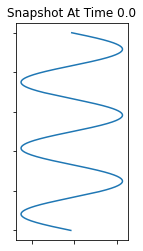

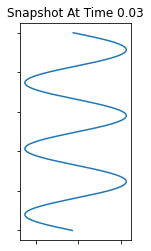

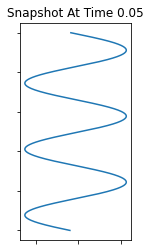

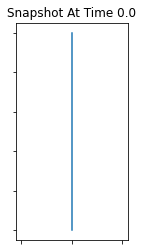

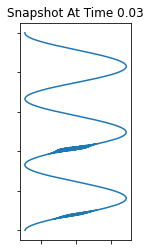

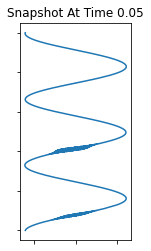

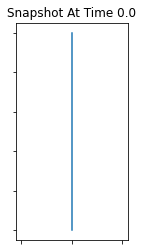

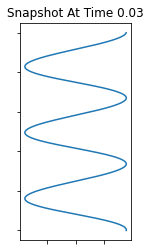

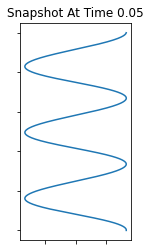

In [16]:
# Plot Snapshots 
def plot_rotated(data, time, figsize=(2,4), tot_time = Tlngth, snaps=snaps):
    """
    Plot the data rotated 90 degrees clockwise for a given time index.

    Parameters:
    - data: The dataset (ntot, vtot, etot)
    - time: The time index for which the data should be plotted
    - title_prefix: The prefix for the plot's title (e.g. "Density")
    """
    data = np.flip(data[time])
    fig = plt.figure(figsize=figsize)
    plt.plot(data, X)
    # plt.gca().invert_xaxis()  # Invert the x-axis
    plt.title(f"Snapshot At Time {round(tot_time/snaps*time,2)}")
    plt.xticks(visible=False)
    plt.yticks(visible=False)

    plt.show()
    
# Example of how to use the function:
plot_rotated(ntot, 0)
plot_rotated(ntot, int(snaps/2))
plot_rotated(ntot, snaps)

plot_rotated(vtot, 0)
plot_rotated(vtot, int(snaps/2))
plot_rotated(vtot, snaps)

plot_rotated(etot, 0)
plot_rotated(etot, int(snaps/2))
plot_rotated(etot, snaps)

Text(0, 0.5, 'Density')

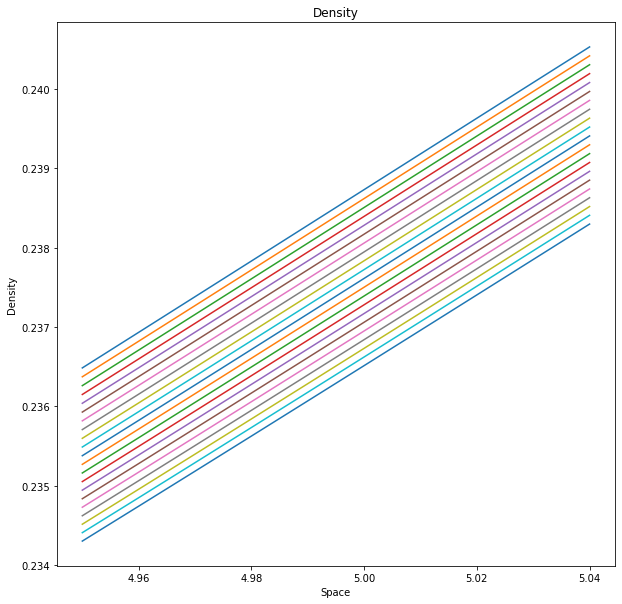

In [17]:
# Plot Boundary Condition
midpoint = int(Xnum/2)
bandwidth = 5

ntot_shift = half_domain_shift(ntot)[:,midpoint-bandwidth:midpoint+bandwidth]
vtot_shift = half_domain_shift(vtot)[:,midpoint-bandwidth:midpoint+bandwidth]
X_shift = X[midpoint-bandwidth:midpoint+bandwidth]

fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X_shift, ntot_shift.T)
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")

In [18]:
plt.rcParams['font.size'] = 16

def data_DMD(data, rank):    
    # Instantiate the DMD class and fit the data
    dmd = DMD(svd_rank=rank)
    fit = dmd.fit(data.T)
    return fit
    
def plot_DMD_eigs(dmd):
    # Print the distance of each eigenvalue from the unit circle
    for eig in dmd.eigs:
        distance = np.abs(eig) - 1
        print(f"Eigenvalue {eig}: distance from unit circle {distance}")

    # Plot the eigenvalues
    plot_eigs(dmd, show_axes=True, show_unit_circle=True)
    
def plot_DMD_modes(dmd, rank, x=X):
    # Plot the modes
    plt.figure(figsize=(8*rank, 6))
    for i, mode in enumerate(dmd.modes.T, 1):
        plt.subplot(1, rank, i)
        plt.plot(x, mode.real.T)
        plt.title(f"Mode {i}")
    plt.show()

def plot_all_DMD_modes(dmd, rank, x=X):
    # Plot the modes
    plt.figure(figsize=(8, 6))
    for i, mode in enumerate(dmd.modes.T, 1):
        plt.plot(x, mode.real.T)
        plt.title(f"Modes")
    plt.show()

def plot_DMD_dynamics(dmd, rank, t=Snap):
    # Plot the dynamics
    plt.figure(figsize=(8*rank, 6))
    for i, dynamic in enumerate(dmd.dynamics, 1):
        plt.subplot(1, rank, i)
        plt.plot(t, dynamic.real)
        plt.title(f"Dynamic {i}")
        
        plt.tight_layout()
        
    plt.show()

def reconstruct_DMD(data, dmd, x=X, t=Snap):
    tgrid, xgrid = np.meshgrid(x, Snap, indexing='ij')
    
    # Reconstruct the data and plot the original, reconstructed, and error
    reconstructed_data = dmd.reconstructed_data.real
    error = data.T - reconstructed_data
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 6))
    titles = ["Original Data", "Reconstructed Data", "Absolute Error"]
    datasets = [data.T, reconstructed_data, np.abs(error)]

    for ax, title, dset in zip(axs, titles, datasets):
        # c = ax.pcolormesh(xgrid, tgrid, dset.T, shading='auto')
        c = ax.imshow(dset, aspect = 'auto', origin = 'lower', cmap='plasma')
        ax.set_title(title)
        fig.colorbar(c, ax=ax)
    plt.show()
    
    print("Frobenius Norm Error: ", np.sqrt(np.sum((data.T-reconstructed_data)**2)))
    print("Norm Difference/Norm Data: ", np.sqrt(np.sum((data.T-reconstructed_data)**2))/np.sqrt(np.sum((data.T)**2)))

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x00000283148DE340>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


Eigenvalue (1.0053702787750665+0j): distance from unit circle 0.0053702787750664616
Eigenvalue (1.0000027167036074+0j): distance from unit circle 2.7167036074082773e-06
Eigenvalue (0.9961300134475463+0j): distance from unit circle -0.0038699865524537413
Eigenvalue (0.9711591654392301+0j): distance from unit circle -0.028840834560769912
Eigenvalue (0.7629587035084407+0j): distance from unit circle -0.23704129649155925
Eigenvalue (0.481635882346241+0j): distance from unit circle -0.518364117653759
Eigenvalue (-0.1415890380902214+0.236359061406323j): distance from unit circle -0.7244767494090705
Eigenvalue (-0.1415890380902214-0.236359061406323j): distance from unit circle -0.7244767494090705
Eigenvalue (-0.6238429649637409+0.0086533001449994j): distance from unit circle -0.37609702313729043
Eigenvalue (-0.6238429649637409-0.0086533001449994j): distance from unit circle -0.37609702313729043


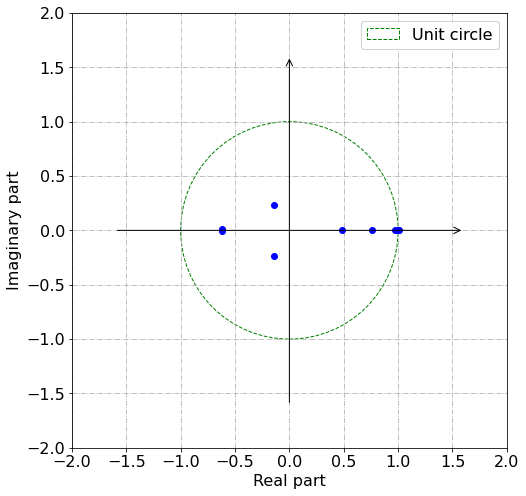

In [19]:
ddt_ntot = (ntot - np.roll(ntot, 1, axis = 1))#/(Tlngth/snaps)
ddt_ntot = (ntot - np.roll(ntot, 1, axis = 1)) + nmean
data_dmd = np.hstack((ntot, ddt_ntot))

data_dmd = ntot

# plot_DMD_eigs(dmd)
# plot_DMD_modes(dmd, dmd_rank)
# plot_DMD_dynamics(dmd, dmd_rank)
# reconstruct_DMD(data, dmd)

# dmd_rank = 1
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

dmd_rank = 10
dmd = data_DMD(data_dmd, dmd_rank)
plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# print(dmd.modes.T.shape)
# plot_DMD_modes(dmd, dmd_rank, np.concatenate((X,X)))
# reconstruct_DMD(data_dmd, dmd, X, Snap)
# reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

# dmd_rank = 5
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

# dmd_rank = 10
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

# dmd_rank = 20
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

# dmd_rank = 50
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

# dmd_rank = 101
# dmd = data_DMD(data_dmd, dmd_rank)
# # plot_DMD_eigs(dmd)
# plot_DMD_dynamics(dmd, dmd_rank)
# # plot_DMD_modes(dmd, dmd_rank)
# # reconstruct_DMD(data_dmd, dmd, np.concatenate((X,X)), Snap)

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


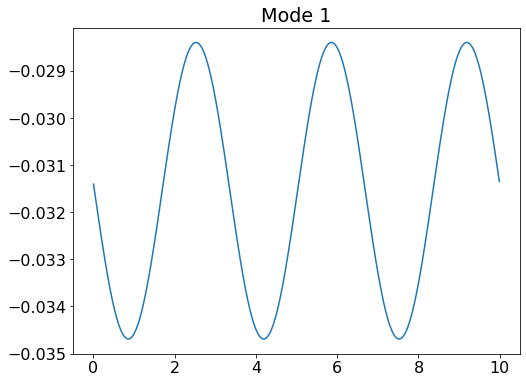

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


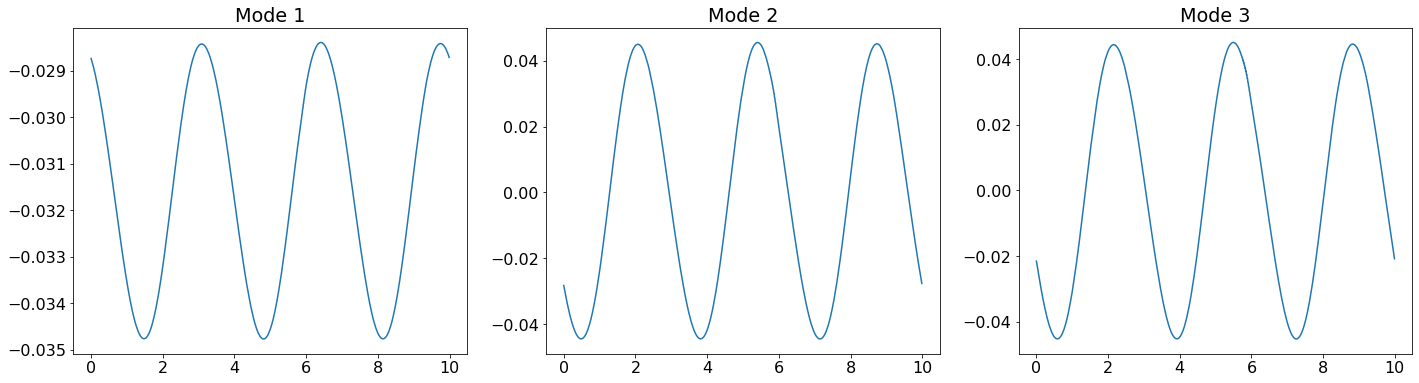

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


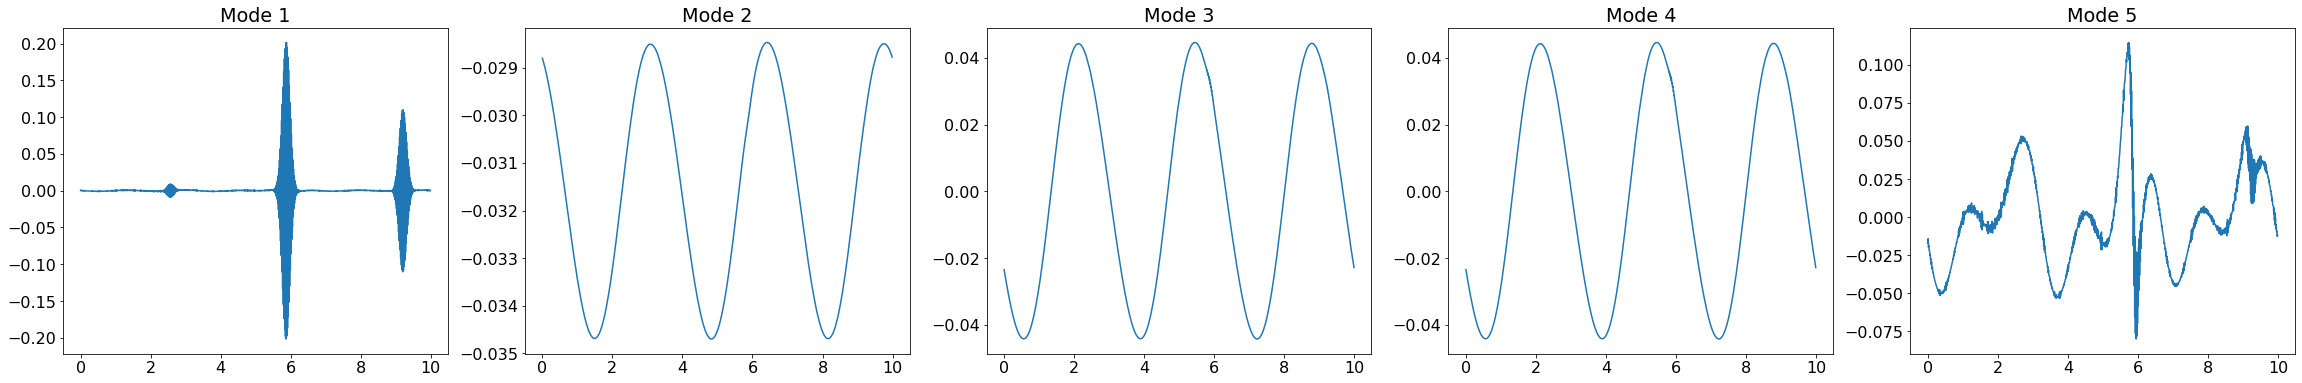

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


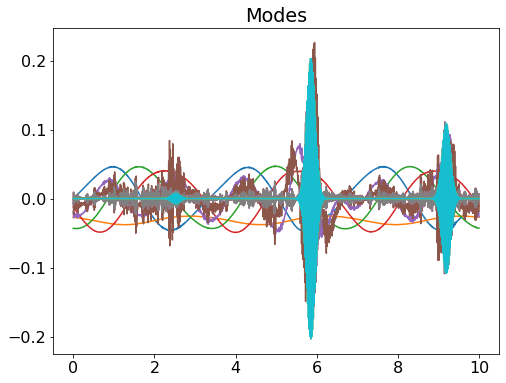

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


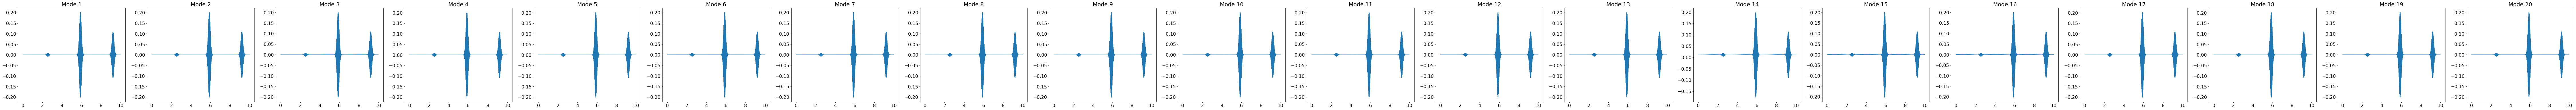

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3181735516228.36. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


In [20]:
data_dmd = ntot
dmd_rank = 20

# plot_DMD_eigs(dmd)
# plot_DMD_modes(dmd, dmd_rank)
# plot_DMD_dynamics(dmd, dmd_rank)
# reconstruct_DMD(data, dmd)

dmd_rank = 1
dmd = data_DMD(data_dmd, dmd_rank)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 3
dmd = data_DMD(data_dmd, dmd_rank)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 5
dmd = data_DMD(data_dmd, dmd_rank)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 10
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
plot_all_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 20
dmd = data_DMD(data_dmd, dmd_rank)
plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 40
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

dmd_rank = 80
dmd = data_DMD(data_dmd, dmd_rank)
# plot_DMD_modes(dmd, dmd_rank)
# reconstruct_DMD(data_dmd, dmd)

# Plotting: FFT

In [21]:
# def fft(arr):
#     shift_arr = np.fft.ifftshift(arr)
#     shift_fft = np.fft.fft2(shift_arr)
#     fft = np.fft.fftshift(shift_arr)
#     return fft

def fft(arr):
    return np.fft.fftshift(np.fft.fft2(arr))

def fold_average_along_axis(arr, axis=0):
    """
    Fold and average an ndarray along the specified axis.

    Parameters:
        array (numpy.ndarray): Input ndarray.
        axis (int, optional): Axis along which to fold and average (default is 0 for rows).

    Returns:
        numpy.ndarray: Folded and averaged result.
    """
    shape = list(arr.shape)
    shape[axis] = (shape[axis] + 1) // 2  # Calculate the size after folding

    left = arr.take(indices=range(0,shape[axis]), axis=axis)
    right = arr.take(indices=range(-shape[axis],0), axis=axis)
    
    fold_right = np.flip(right, axis=axis)
    folded_avg = (left+fold_right)/2
    return folded_avg

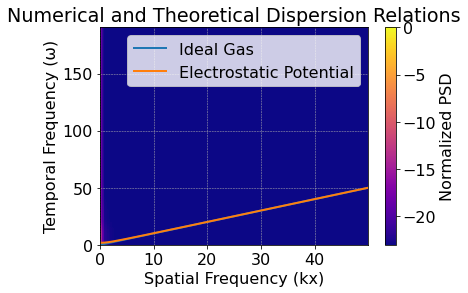

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Create frequency domains for spatial and temporal dimensions
kx = np.fft.fftfreq(Xnum, dx)
kt = np.fft.fftfreq(snaps + 1, Tlngth / snaps)

kx_shifted = np.fft.fftshift(kx)
kt_shifted = np.fft.fftshift(kt)

# Compute the 2D FFT of ntot and shift
ntot_fft_shifted = np.fft.fftshift(np.fft.fft2(ntot - np.mean(ntot)))

# Compute non-negative indices for space and time
nn_indices_x = np.where(kx_shifted >= 0)
nn_indices_t = np.where(kt_shifted >= 0)

# Extract non-negative frequencies part
nn_ntot_fft = ntot_fft_shifted[np.ix_(nn_indices_t[0], nn_indices_x[0])]
nnkx = kx_shifted[nn_indices_x]
nnkt = kt_shifted[nn_indices_t]
pkx = nnkx[nnkx>0]
pkt = nnkt[nnkt>0]

# Compute the magnitude squared to get power spectral density
power_spectral_density = np.abs(nn_ntot_fft)**2
# Normalize the power spectral density
psd_normalized = power_spectral_density / np.max(power_spectral_density)

# Plot the numerical dispersion relations as a colormap
extent = [nnkx.min(), nnkx.max(), nnkt.min(), nnkt.max()]
plt.imshow(np.log(psd_normalized + 1e-10), aspect='auto', extent=extent, origin='lower', cmap='plasma')

### Theoretical Dispersion Relations ###
# Assuming Ideal Gas - No phi nor excess correlations
acoustic_wave_freq = np.mean(etot)
disp_rel_ideal = nnkx * np.sqrt(acoustic_wave_freq)

# Assuming Electrostatic Potential - Include Poisson but no excess correlations
mean_field_correction_freq = 4 * np.pi * Gamma * nmean / pkx**2
disp_rel_phi = np.zeros_like(pkx)
disp_rel_phi[0] = np.sqrt(4 * np.pi * Gamma * nmean)
disp_rel_phi[1:] = (pkx * np.sqrt(acoustic_wave_freq + mean_field_correction_freq))[1:]

# Plotting the theoretical dispersion relations
plt.plot(nnkx, disp_rel_ideal, label='Ideal Gas', linewidth=2)
plt.plot(pkx, disp_rel_phi, label='Electrostatic Potential', linewidth=2)

plt.xlabel('Spatial Frequency (kx)')
plt.ylabel('Temporal Frequency (ω)')
plt.title('Numerical and Theoretical Dispersion Relations')
plt.colorbar(label='Normalized PSD')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(nnkt.min(), nnkt.max())
plt.show()

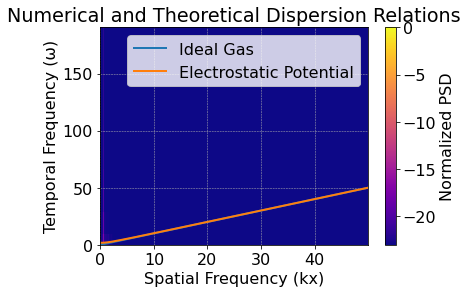

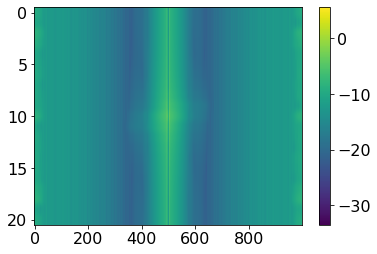

In [23]:
def plot_dispersion_relations(ntot, etot, Xnum, dx, snaps, Tlngth, Gamma, nmean):
    # Create frequency domains for spatial and temporal dimensions
    kx = np.fft.fftfreq(Xnum, dx)
    kt = np.fft.fftfreq(snaps + 1, Tlngth / snaps)
    kx_shifted = np.fft.fftshift(kx)
    kt_shifted = np.fft.fftshift(kt)

    # Compute the 2D FFT of ntot and shift
    ntot_fft_shifted = np.fft.fftshift(np.fft.fft2(ntot - np.mean(ntot)))

    # Compute non-negative indices for space and time
    nn_indices_x = np.where(kx_shifted >= 0)
    nn_indices_t = np.where(kt_shifted >= 0)

    # Extract non-negative frequencies part
    nn_ntot_fft = ntot_fft_shifted[np.ix_(nn_indices_t[0], nn_indices_x[0])]
    nnkx = kx_shifted[nn_indices_x]
    nnkt = kt_shifted[nn_indices_t]

    # Compute the magnitude squared to get power spectral density
    power_spectral_density = np.abs(nn_ntot_fft)**2
    # Normalize the power spectral density
    psd_normalized = power_spectral_density / np.max(power_spectral_density)

    # Use pcolormesh for the colormap
    X, Y = np.meshgrid(nnkx, nnkt)
    plt.pcolormesh(X, Y, np.log(psd_normalized + 1e-10), shading='auto', cmap='plasma')

    ### Theoretical Dispersion Relations ###
    # Assuming Ideal Gas - No phi nor excess correlations
    acoustic_wave_freq = np.mean(etot)
    disp_rel_ideal = nnkx * np.sqrt(acoustic_wave_freq)

    # Assuming Electrostatic Potential - Include Poisson but no excess correlations
    mean_field_correction_freq = 4 * np.pi * Gamma * nmean / pkx**2
    disp_rel_phi = np.zeros_like(nnkx)
    disp_rel_phi[0] = np.sqrt(4 * np.pi * Gamma * nmean)
    disp_rel_phi[1:] = (pkx * np.sqrt(acoustic_wave_freq + mean_field_correction_freq))

    # Plotting the theoretical dispersion relations
    plt.plot(nnkx, disp_rel_ideal, label='Ideal Gas', linewidth=2)
    plt.plot(nnkx, disp_rel_phi, label='Electrostatic Potential', linewidth=2)

    plt.xlabel('Spatial Frequency (kx)')
    plt.ylabel('Temporal Frequency (ω)')
    plt.title('Numerical and Theoretical Dispersion Relations')
    plt.colorbar(label='Normalized PSD')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(nnkt.min(), nnkt.max())
    plt.show()

# You can now call the function using the required parameters:
plot_dispersion_relations(ntot, etot, Xnum, dx, snaps, Tlngth, Gamma, nmean)

centered_ntot = ntot - np.mean(ntot)
ntot_fft = np.fft.fftshift(np.fft.fft2(centered_ntot))
plt.imshow(np.log(np.abs(ntot_fft)), aspect='auto')
plt.colorbar()

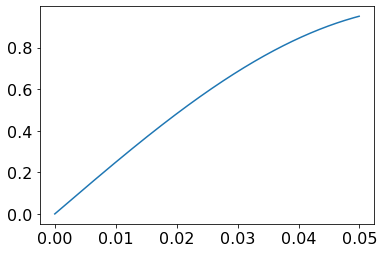

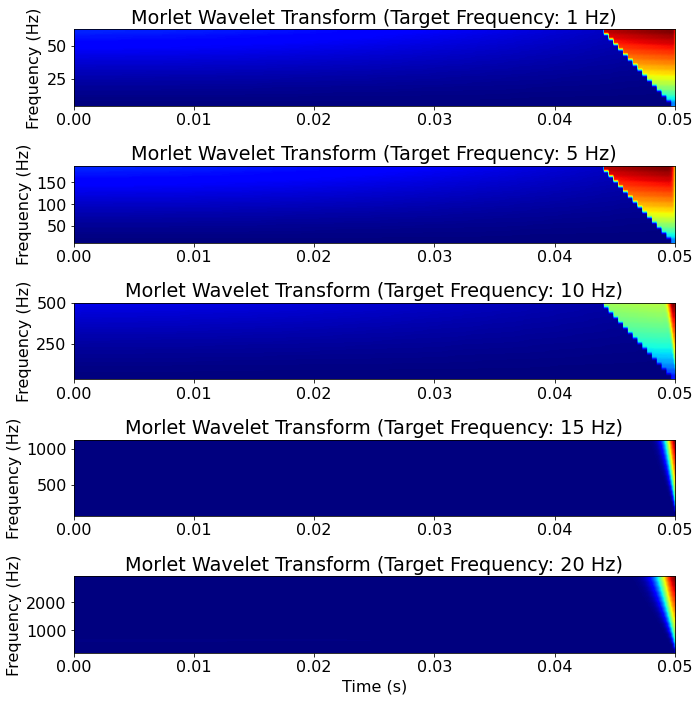

In [24]:
def plot_morlet_wavelet(data, target_frequencies, fs=snaps/Tlngth, Snap=Snap):
    # Create a figure
    fig, axs = plt.subplots(len(target_frequencies), 1, figsize=(10, 2*len(target_frequencies)))
    
    for i, f_k in enumerate(target_frequencies):
        deltaf = np.min(np.abs(data_freqs - f_k))
        bandwidth = np.sqrt(2 * np.log(2)) * f_k / (np.pi * 0.5 * deltaf)
        center_freq = np.sqrt(2) * bandwidth
        wavelet = f'cmor{center_freq}-{bandwidth}'
        
        # Calculate the continuous wavelet transform
        coeffs, freqs = pywt.cwt(data, scales=np.arange(1, 16), wavelet=wavelet, sampling_period=1/fs)
        
        # Plot the transform
        axs[i].imshow(np.abs(coeffs), extent=[Snap[0], Snap[-1], freqs.min(), freqs.max()], 
                      aspect='auto', cmap='jet', origin='lower')
        axs[i].set_title(f'Morlet Wavelet Transform (Target Frequency: {f_k} Hz)')
        axs[i].set_ylabel('Frequency (Hz)')
        
    axs[-1].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
snaps = 1000
S = np.linspace(0, Tlngth, snaps, endpoint=False)
data_freqs = 2*np.pi*np.array([4, 6, 10])
data = np.sin(data_freqs[0]*S) * (S<.5) + np.sin(data_freqs[2]*S) * (S>=.5) # + np.sin(data_freqs[1]*S)*(S>=.2)*(S<.6) 
target_frequencies = [1,5, 10, 15 ,20]

plt.plot(S,data)


plot_morlet_wavelet(data, target_frequencies, fs=snaps)

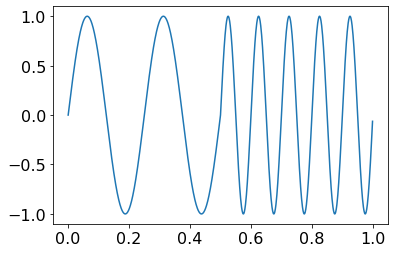

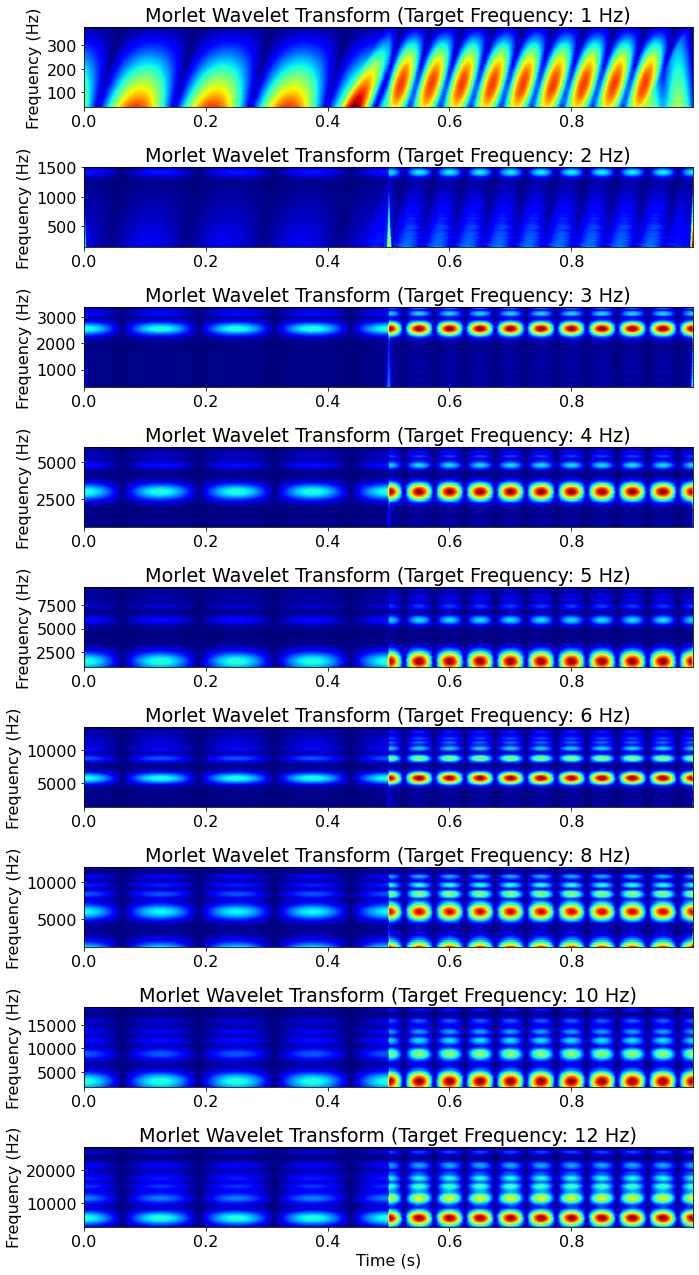

In [25]:
def plot_morlet_wavelet(data, target_frequencies, fs=1.0, deltaf_prime=0.1):
    if data.ndim != 1:
        raise ValueError("Input data must have shape (int,)")
    
    time = np.arange(data.shape[0]) / fs
    fig, axs = plt.subplots(len(target_frequencies), 1, figsize=(10, 2 * len(target_frequencies)), squeeze=False)
    
    for i, f_k in enumerate(target_frequencies):
        # Calculate the nearest frequency to the target frequency
        nearest_frequency = min(target_frequencies, key=lambda x: abs(x - f_k) if x != f_k else float('inf'))
        
        # Calculate the bandwidth
        bandwidth = np.sqrt(2 * np.log(2)) * f_k / (np.pi * abs(f_k - nearest_frequency))
        
        # Calculate the center frequency for the Morlet wavelet
        center_freq = np.sqrt(2 * bandwidth)
        
        # Define the wavelet
        wavelet = f'cmor{center_freq}-{bandwidth}'
        
        # Calculate the scales
        scales = np.linspace(1/f_k, 10/f_k, 100)
        
        # Perform the continuous wavelet transform
        coeffs, freqs = pywt.cwt(data, scales, wavelet, sampling_period=1/fs)
        
        # Plot the wavelet transformation
        im = axs[i, 0].imshow(np.abs(coeffs), extent=[time[0], time[-1], freqs.min(), freqs.max()], aspect='auto', cmap='jet', interpolation='bilinear')
        axs[i, 0].set_ylabel('Frequency (Hz)')
        axs[i, 0].set_title(f'Morlet Wavelet Transform (Target Frequency: {f_k} Hz)')
    
    axs[-1, 0].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
snaps = 1000
S = np.linspace(0, 1, snaps, endpoint=False)
data_freqs = 2*np.pi*np.array([4, 6, 10])
data = np.sin(data_freqs[0]*S) * (S<.5) + np.sin(data_freqs[2]*S) * (S>=.5) # + np.sin(data_freqs[1]*S)*(S>=.2)*(S<.6) 
target_frequencies = [1,2,3,4,5,6,8,10,12]

plt.plot(S,data)


plot_morlet_wavelet(data, target_frequencies, fs=snaps)

C:\Users\chris\anaconda3\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


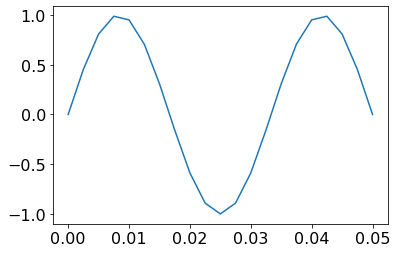

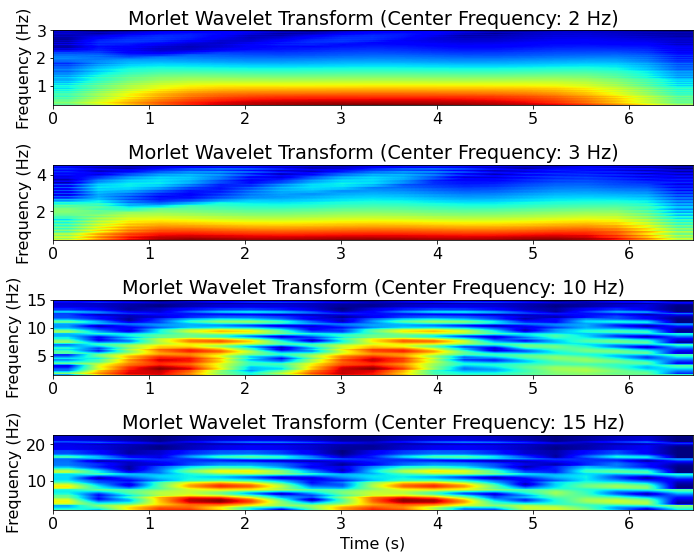

In [26]:
def plot_morlet_wavelet(data, center_frequencies, fs=1.0):
    if data.ndim != 1:
        raise ValueError("Input data must have shape (int,)")

    time = np.arange(data.shape[0]) / fs
    fig, axs = plt.subplots(len(center_frequencies), 1, figsize=(10, 2 * len(center_frequencies)), squeeze=False)
    
    for i, freq in enumerate(center_frequencies):
        scales = np.linspace(1/freq, 10/freq, 100)  # Adjust the range and number of scales as needed
        coeffs, freqs = pywt.cwt(data, scales, 'cmor', sampling_period=1/fs)
        
        if np.isclose(freqs.min(), freqs.max()):
            print(f"Warning: Frequency range is too narrow for center frequency {freq} Hz. Adjusting scales might be necessary.")
            continue

        im = axs[i, 0].imshow(np.abs(coeffs), extent=[time[0], time[-1], freqs.min(), freqs.max()], aspect='auto', cmap='jet', interpolation='bilinear')
        axs[i, 0].set_ylabel('Frequency (Hz)')
        axs[i, 0].set_title(f'Morlet Wavelet Transform (Center Frequency: {freq} Hz)')
    
    axs[-1, 0].set_xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Example usage
# Generate some example data
np.random.seed(42)
freqs = [1,3,10,20]
data = np.sin(2*np.pi*30*Snap)*(Snap<snaps/4) + np.sin(2*np.pi*80*Snap)*np.logical_and(Snap>=snaps/4, Snap<=snaps/2) + np.sin(2*np.pi*20*Snap)*(Snap>snaps/2)


plt.plot(Snap, data)
# Define the center frequencies
center_frequencies = [2, 3, 10, 15]

# Plot the Morlet wavelet transform
plot_morlet_wavelet(data, center_frequencies, fs=3)

In [27]:
# Wavelet Transformation
wavelet_name = 'morl'
scales = np.arange(1,257)  # TODO: FIX

wvlt_data_IC = ntot[0]
# wvlt_data_Mid = ntot[int(snaps/2)]
wvlt_data_End = ntot[-1]

# wvlt_data_IC = ntot[0,:]
# wvlt_data_Mid = ntot[int(Tlngth/2),:]
# wvlt_data_End = ntot[-1,:]

print(wvlt_data_IC.shape)
print(X.shape)

[coefficients_IC, frequencies_IC] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=1000)
[coefficients_Mid, frequencies_Mid] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=10)
[coefficients_End, frequencies_End] = pywt.cwt(data=wvlt_data_IC, scales=scales, wavelet=wavelet_name, sampling_period=.1)

wavelet_domain = [0, Xlngth, scales.min(), scales.max()]

fig, ax = plt.subplots(2,3, figsize=subplot_figsize)
wvlt_IC_sgnl_plt = ax[0,0].plot(X,wvlt_data_IC)
wvlt_Mid_sgnl_plt = ax[0,1].plot(X,wvlt_data_Mid)
wvlt_End_sgnl_plt = ax[0,2].plot(X,wvlt_data_End)


wvlt_IC_plt = ax[1,0].imshow(coefficients_IC, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xlabel('Time')
# ax2 = ax[1,0].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_IC]
# strs = [str(round(freq)) for freq in frequencies_IC]
# ax2.set_yticks(np.arange(coefficients_IC.shape[0]))
# ax2.set_yticklabels(strs)

wvlt_Mid_plt = ax[1,1].imshow(coefficients_Mid, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_xlabel('Time')
# ax2 = ax[1,1].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_Mid]
# strs = [str(round(freq)) for freq in frequencies_Mid]
# ax2.set_yticks(np.arange(coefficients_Mid.shape[0]))
# ax2.set_yticklabels(strs)

wvlt_End_plt = ax[1,2].imshow(coefficients_End, extent=wavelet_domain, aspect='auto', cmap='plasma')
ax[1,2].set_ylabel('Frequency')
ax[1,2].set_xlabel('Time')
# ax2 = ax[1,2].twinx()
# ax2.set_ylabel('period [s]')

# strs = [str(round(1 / freq, 3)) for freq in frequencies_End]
# strs = [str(round(freq)) for freq in frequencies_End]
# ax2.set_yticks(np.arange(coefficients_End.shape[0]))
# ax2.set_yticklabels(strs)

fig.colorbar(wvlt_IC_plt, ax=ax[1,0])
fig.colorbar(wvlt_Mid_plt, ax=ax[1,1])
fig.colorbar(wvlt_End_plt, ax=ax[1,2])

plt.show()

(1000,)
(1000,)


NameError: name 'subplot_figsize' is not defined

In [ ]:
%matplotlib inline

wvlt_coeffs = []
wvlt_freqs = []

for ii in range(len(T)):
    ntot_slice = ntot[:, ii]
    [wvlt_coeff, wvlt_freq] = pywt.cwt(ntot_slice, scales, wavelet_name, min_dt)
    wvlt_coeffs.append(wvlt_coeff)
    wvlt_freqs.append(wvlt_freq)

def change_plot(frame_number, data, plot):
#     frame_number %= int(len(data))
    plot[0].remove()
    plot[0] = ax.imshow(data[frame_number], cmap="plasma", extent=wavelet_domain, aspect='auto')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time')
    
    ax2 = ax.twinx()
    ax2.set_ylabel('Period')
#     # TODO: Fix Period Labeling
#     strs = [str(round(1 / freq, 3)) for freq in frequencies_End]
#     strs = [str(round(freq)) for freq in frequencies_End]
#     ax2.set_yticks(np.arange(coefficients.shape[0]))
#     ax2.set_yticklabels(strs)

wavelet_domain = [0, Xlngth, np.max(scales), np.min(scales)]
    
fig = plt.figure(figsize=single_plot_figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('Frequency')
ax.set_xlabel('Time')
ax2 = ax.twinx()
ax2.set_ylabel('Period')

# Initialize the first frame
plot = [ax.imshow(wvlt_coeffs[0], cmap='plasma', extent=wavelet_domain, aspect='auto')]

cbar = plt.colorbar(plot[0], ax=ax)

# Animate Wavelet Transformation
ani = FuncAnimation(fig, change_plot, frames=range(len(T)), fargs=(wvlt_coeffs, plot), interval=10, save_count=T)

# plt.tight_layout()
# plt.show()
HTML(ani.to_jshtml())
# ani.save(filename=r"C:\Users\chris\OneDrive\Desktop\anim.gif", writer='pillow')

In [ ]:
# Forecasting



In [ ]:
# Var(Number)



In [ ]:
# Kernel DMD - Nonlinear DMD

